In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "../../PlantVillage (copy)"
CHANNELS = 3
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
 "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

10 ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


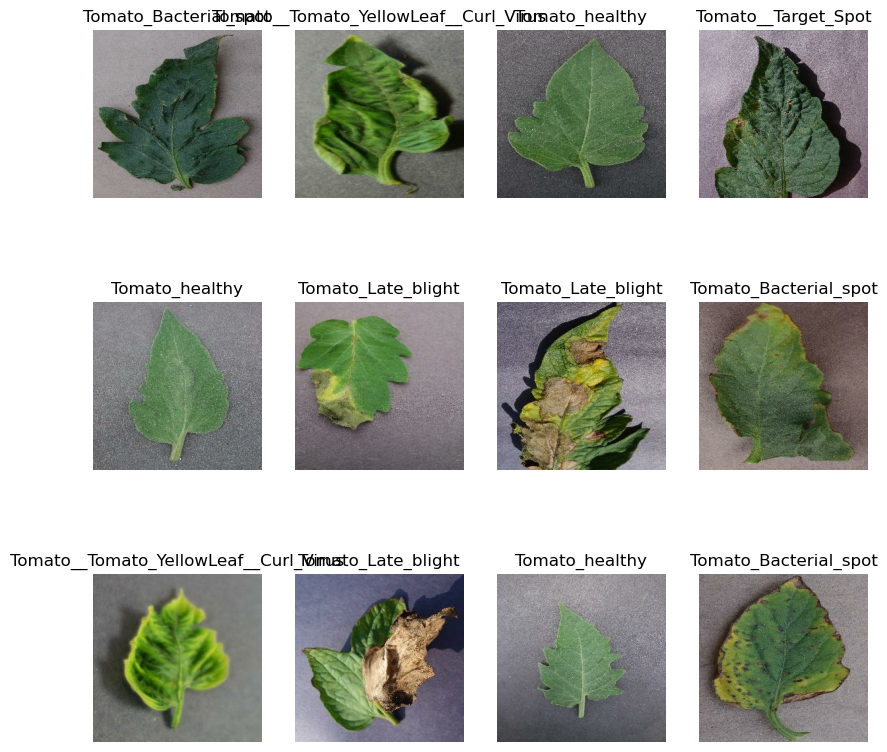

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
train_size = 0.8
len(dataset)*train_size

400.8

In [8]:
train_ds = dataset.take(54)
len(train_ds)

54

In [9]:
test_ds = dataset.skip(54)
len(test_ds)

447

In [11]:
val_size=0.1
len(dataset)*val_size

50.1

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

441

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

400

In [23]:
len(val_ds)

50

In [25]:
len(test_ds)

51

In [27]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [31]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [33]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

os.makedirs("checkpoints", exist_ok=True)

checkpoint = ModelCheckpoint(
    filepath='checkpoints/model_epoch_{epoch:02d}.h5',
    save_freq='epoch',
    save_best_only=False,
    verbose=1
)

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=50,
    callbacks=[checkpoint]  # NE PAS OUBLIER
)

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3066 - loss: 1.9133
Epoch 1: saving model to checkpoints/model_epoch_01.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 600s 1s/step - accuracy: 0.3068 - loss: 1.9127 - val_accuracy: 0.5469 - val_loss: 1.3140
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5880 - loss: 1.1743
Epoch 2: saving model to checkpoints/model_epoch_02.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 460s 1s/step - accuracy: 0.5881 - loss: 1.1740 - val_accuracy: 0.6106 - val_loss: 1.1603
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7110 - loss: 0.8192
Epoch 3: saving model to checkpoints/model_epoch_03.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 471s 1s/step - accuracy: 0.7110 - loss: 0.8191 - val_accuracy: 0.7469 - val_loss: 0.7103
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7891 - loss: 0.5897
Epoch 4: saving model to checkpoints/model_epoch_04.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 478s 1s/step - accuracy: 0.7891 - loss: 0.5896 - val_accuracy: 0.8019 - val_loss: 0.5676
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8339 - loss: 0.4643
Epoch 5: saving model to checkpoints/model_epoch_05.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 477s 1s/step - accuracy: 0.8339 - loss: 0.4643 - val_accuracy: 0.8012 - val_loss: 0.6535
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8681 - loss: 0.3771
Epoch 6: saving model to checkpoints/model_epoch_06.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 479s 1s/step - accuracy: 0.8681 - loss: 0.3771 - val_accuracy: 0.8425 - val_loss: 0.5150
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8861 - loss: 0.3230
Epoch 7: saving model to checkpoints/model_epoch_07.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 515s 1s/step - accuracy: 0.8861 - loss: 0.3230 - val_accuracy: 0.8112 - val_loss: 0.6062
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8908 - loss: 0.3010
Epoch 8: saving model to checkpoints/model_epoch_08.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 548s 1s/step - accuracy: 0.8908 - loss: 0.3010 - val_accuracy: 0.8706 - val_loss: 0.3832
Epoch 9/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9088 - loss: 0.2626
Epoch 9: saving model to checkpoints/model_epoch_09.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 572s 1s/step - accuracy: 0.9088 - loss: 0.2626 - val_accuracy: 0.8781 - val_loss: 0.3523
Epoch 10/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9203 - loss: 0.2273
Epoch 10: saving model to checkpoints/model_epoch_10.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 500s 1s/step - accuracy: 0.9203 - loss: 0.2273 - val_accuracy: 0.8925 - val_loss: 0.3521
Epoch 11/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.9274 - loss: 0.2131
Epoch 11: saving model to checkpoints/model_epoch_11.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 295s 736ms/step - accuracy: 0.9274 - loss: 0.2131 - val_accuracy: 0.8431 - val_loss: 0.4419
Epoch 12/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9221 - loss: 0.2188
Epoch 12: saving model to checkpoints/model_epoch_12.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 293s 732ms/step - accuracy: 0.9221 - loss: 0.2188 - val_accuracy: 0.9150 - val_loss: 0.2502
Epoch 13/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.9392 - loss: 0.1774
Epoch 13: saving model to checkpoints/model_epoch_13.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 293s 732ms/step - accuracy: 0.9392 - loss: 0.1774 - val_accuracy: 0.9150 - val_loss: 0.2420
Epoch 14/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9411 - loss: 0.1740
Epoch 14: saving model to checkpoints/model_epoch_14.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 290s 723ms/step - accuracy: 0.9411 - loss: 0.1740 - val_accuracy: 0.9525 - val_loss: 0.1351
Epoch 15/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.9424 - loss: 0.1721
Epoch 15: saving model to checkpoints/model_epoch_15.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 294s 733ms/step - accuracy: 0.9423 - loss: 0.1721 - val_accuracy: 0.9187 - val_loss: 0.2669
Epoch 16/50
112/400 ━━━━━━━━━━━━━━━━━━━━ 3:14 674ms/step - accuracy: 0.9431 - loss: 0.1592

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Chemin vers le dernier checkpoint sauvegardé (ici epoch 15)
checkpoint_path = 'checkpoints/model_epoch_25.h5'

# Recharger le modèle sauvegardé
model = tf.keras.models.load_model(checkpoint_path)

# Recompiler le modèle
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Redéfinir le callback ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='checkpoints/model_epoch_{epoch:02d}.h5',
    save_freq='epoch',
    save_best_only=False,
    verbose=1
)

# Relancer l'entraînement depuis epoch 16
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    initial_epoch=25,
    callbacks=[checkpoint]
)


Epoch 26/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.9555 - loss: 0.1378
Epoch 26: saving model to checkpoints/model_epoch_26.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 429s 964ms/step - accuracy: 0.9555 - loss: 0.1378 - val_accuracy: 0.9550 - val_loss: 0.1303
Epoch 27/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.9599 - loss: 0.1117
Epoch 27: saving model to checkpoints/model_epoch_27.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 356s 888ms/step - accuracy: 0.9599 - loss: 0.1117 - val_accuracy: 0.9513 - val_loss: 0.1670
Epoch 28/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - accuracy: 0.9636 - loss: 0.1036
Epoch 28: saving model to checkpoints/model_epoch_28.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 344s 859ms/step - accuracy: 0.9636 - loss: 0.1036 - val_accuracy: 0.9663 - val_loss: 0.0941
Epoch 29/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.9635 - loss: 0.1033
Epoch 29: saving model to checkpoints/model_epoch_29.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 340s 848ms/step - accuracy: 0.9635 - loss: 0.1033 - val_accuracy: 0.9525 - val_loss: 0.1341
Epoch 30/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.9624 - loss: 0.1122
Epoch 30: saving model to checkpoints/model_epoch_30.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 332s 828ms/step - accuracy: 0.9624 - loss: 0.1122 - val_accuracy: 0.9325 - val_loss: 0.2035
Epoch 31/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.9654 - loss: 0.0993
Epoch 31: saving model to checkpoints/model_epoch_31.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 336s 838ms/step - accuracy: 0.9654 - loss: 0.0993 - val_accuracy: 0.9600 - val_loss: 0.1251
Epoch 32/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.9696 - loss: 0.0905
Epoch 32: saving model to checkpoints/model_epoch_32.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 310s 772ms/step - accuracy: 0.9696 - loss: 0.0905 - val_accuracy: 0.9588 - val_loss: 0.1287
Epoch 33/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.9695 - loss: 0.0894
Epoch 33: saving model to checkpoints/model_epoch_33.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 283s 704ms/step - accuracy: 0.9695 - loss: 0.0894 - val_accuracy: 0.9506 - val_loss: 0.1550
Epoch 34/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.9670 - loss: 0.0916
Epoch 34: saving model to checkpoints/model_epoch_34.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 278s 695ms/step - accuracy: 0.9670 - loss: 0.0916 - val_accuracy: 0.9281 - val_loss: 0.2293
Epoch 35/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.9562 - loss: 0.1334
Epoch 35: saving model to checkpoints/model_epoch_35.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 280s 697ms/step - accuracy: 0.9562 - loss: 0.1333 - val_accuracy: 0.9650 - val_loss: 0.0978
Epoch 36/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.9713 - loss: 0.0862
Epoch 36: saving model to checkpoints/model_epoch_36.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 277s 692ms/step - accuracy: 0.9713 - loss: 0.0862 - val_accuracy: 0.9769 - val_loss: 0.0856
Epoch 37/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.9723 - loss: 0.0752
Epoch 37: saving model to checkpoints/model_epoch_37.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 276s 687ms/step - accuracy: 0.9723 - loss: 0.0753 - val_accuracy: 0.9006 - val_loss: 0.3742
Epoch 38/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.9680 - loss: 0.1012
Epoch 38: saving model to checkpoints/model_epoch_38.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 278s 692ms/step - accuracy: 0.9680 - loss: 0.1012 - val_accuracy: 0.9700 - val_loss: 0.0774
Epoch 39/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.9718 - loss: 0.0786
Epoch 39: saving model to checkpoints/model_epoch_39.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 280s 698ms/step - accuracy: 0.9718 - loss: 0.0786 - val_accuracy: 0.9669 - val_loss: 0.0948
Epoch 40/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.9743 - loss: 0.0784
Epoch 40: saving model to checkpoints/model_epoch_40.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 274s 685ms/step - accuracy: 0.9743 - loss: 0.0784 - val_accuracy: 0.9769 - val_loss: 0.0828
Epoch 41/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.9751 - loss: 0.0771
Epoch 41: saving model to checkpoints/model_epoch_41.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 273s 682ms/step - accuracy: 0.9751 - loss: 0.0771 - val_accuracy: 0.9356 - val_loss: 0.2068
Epoch 42/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.9712 - loss: 0.0852
Epoch 42: saving model to checkpoints/model_epoch_42.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 273s 681ms/step - accuracy: 0.9712 - loss: 0.0853 - val_accuracy: 0.9744 - val_loss: 0.0754
Epoch 43/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.9792 - loss: 0.0642
Epoch 43: saving model to checkpoints/model_epoch_43.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 281s 699ms/step - accuracy: 0.9792 - loss: 0.0642 - val_accuracy: 0.9206 - val_loss: 0.3136
Epoch 44/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.9742 - loss: 0.0763
Epoch 44: saving model to checkpoints/model_epoch_44.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 277s 693ms/step - accuracy: 0.9742 - loss: 0.0763 - val_accuracy: 0.9613 - val_loss: 0.0999
Epoch 45/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.9776 - loss: 0.0650
Epoch 45: saving model to checkpoints/model_epoch_45.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 280s 700ms/step - accuracy: 0.9776 - loss: 0.0650 - val_accuracy: 0.9375 - val_loss: 0.1853
Epoch 46/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.9772 - loss: 0.0702
Epoch 46: saving model to checkpoints/model_epoch_46.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 279s 697ms/step - accuracy: 0.9772 - loss: 0.0702 - val_accuracy: 0.9812 - val_loss: 0.0569
Epoch 47/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9759 - loss: 0.0715
Epoch 47: saving model to checkpoints/model_epoch_47.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 289s 721ms/step - accuracy: 0.9759 - loss: 0.0715 - val_accuracy: 0.9756 - val_loss: 0.0613
Epoch 48/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.9756 - loss: 0.0661
Epoch 48: saving model to checkpoints/model_epoch_48.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 286s 712ms/step - accuracy: 0.9756 - loss: 0.0661 - val_accuracy: 0.9712 - val_loss: 0.0773
Epoch 49/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.9727 - loss: 0.0763
Epoch 49: saving model to checkpoints/model_epoch_49.h5


400/400 ━━━━━━━━━━━━━━━━━━━━ 287s 715ms/step - accuracy: 0.9727 - loss: 0.0763 - val_accuracy: 0.9531 - val_loss: 0.1523
Epoch 50/50
 15/400 ━━━━━━━━━━━━━━━━━━━━ 4:25 690ms/step - accuracy: 0.9627 - loss: 0.0986